The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


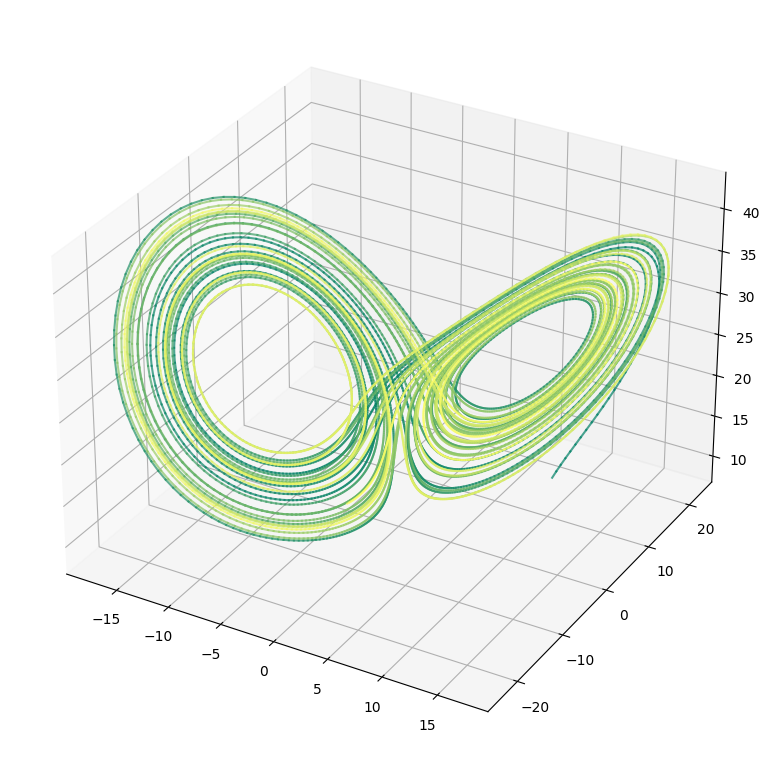

In [4]:
%load_ext autoreload
%autoreload all

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from snn_dpe.tools.data import util, Lorenz
from snn_dpe.tools.network import create_network, run_network_timeseries_nD, reset_network
from snn_dpe.tools.plotting import *
from snn_dpe.tools.plotting import plot_network, plot_spike_raster
from snn_dpe.tools.train.timeseries import (test_timeseries_nD,
                                            train_TS_nD)

"Create a class for the lorenz dataset"
n_tr_data = 5000
n_te_data = 5000


# NOTE: tmax/n defines the resolution of the data and the speed of the particle
LD_data = Lorenz.create_dataset(x0=10,y0=11,z0=11.05,tmax=50,n=n_tr_data+n_te_data, normalize=False) #x0,y0,z0 intial value, tmax=max time, n= number of samples
LD_max = np.max(LD_data)
LD_min = np.min(LD_data)
Lorenz.plot_data(LD_data, plt_len=n_tr_data+n_te_data)

-23.019263485223945
43.52134885426931
8.21190499247013
Number of Synapses: 250


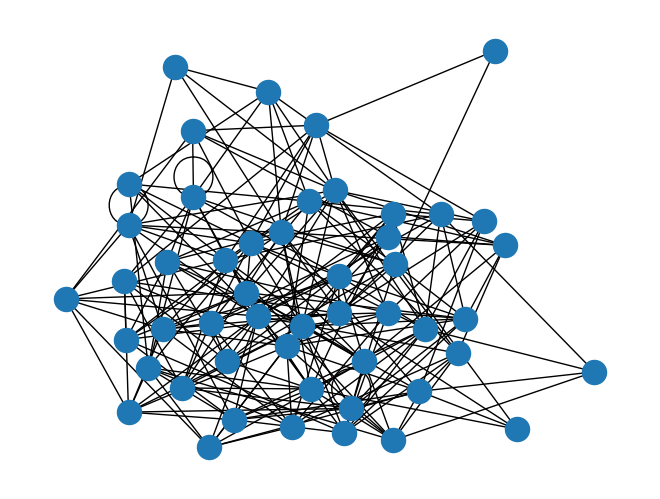

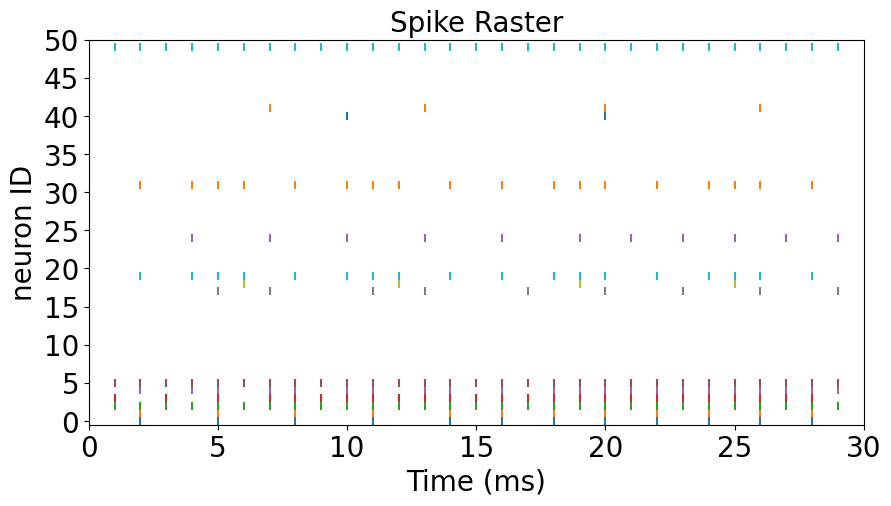

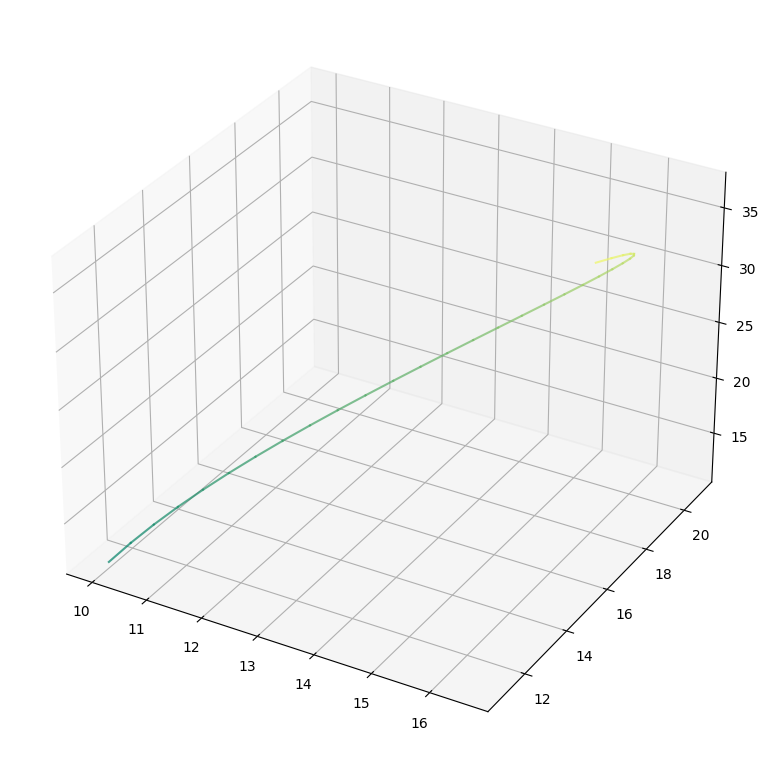

In [5]:
LD_mean = np.mean(LD_data)
print(LD_min)
print(LD_max)
print(LD_mean)

# create a test network and plot it
# network parameters:
n_neurons = 50
synapse_density = 0.1
n_input = 12 #how many neurons will receive potentiation adjustments related to LD
n_synapses = int((n_neurons**2)*synapse_density)
print(f'Number of Synapses: {n_synapses}')

neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.1, LD_max), leak_range = (0.005*LD_max, 0.01*LD_max), weight_factor = LD_max)
plot_network(neurons)

# feed some LD into the network and get the spike raster
LD_test_len = 30
spike_raster = run_network_timeseries_nD(neurons, LD_data[:LD_test_len], n_input)

for n in neurons:
    n.reset()

plot_spike_raster(spike_raster)
Lorenz.plot_data(LD_data, plt_len=LD_test_len)


In [6]:
# split data into training and testing
LD_data_tr = LD_data[:n_tr_data] 
LD_data_te = LD_data[n_te_data:] 

# slice up Lorenz into input, output pairs
input_window_size = 30
output_window_size = 1

LD_inputs_tr, LD_outputs_tr = util.generate_io_pairs(LD_data_tr[:n_tr_data], input_window_size, output_window_size)
LD_inputs_te, LD_outputs_te = util.generate_io_pairs(LD_data_te[:n_te_data], input_window_size, output_window_size)

n_epochs = 3
training_mses, testing_mses, relative_dpe_weights, dpe_bias_relative = train_TS_nD(n_epochs, LD_inputs_tr, LD_outputs_tr, neurons, n_input, silent=False, relative=True)


Training RMSE: 0.1443, Testing RMSE: N/A: 100%|██████████| 4969/4969 [01:17<00:00, 64.07it/s]


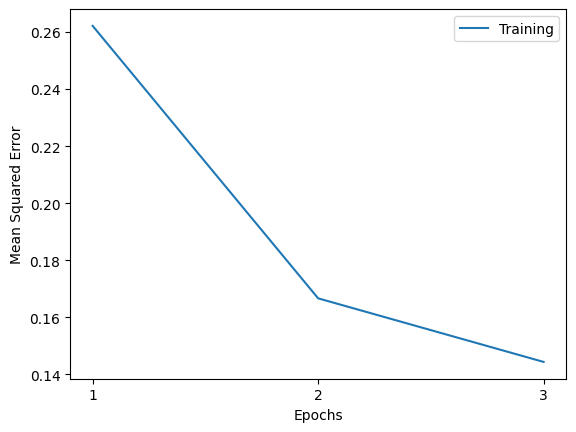

In [7]:
plt.plot(range(n_epochs), training_mses/ (np.max(LD_data_tr)-np.min(LD_data_tr)), label='Training')
# plt.plot(range(n_epochs), testing_mses, label='Testing')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.xticks(range(n_epochs), labels = range(1, n_epochs+1))
plt.legend()
plt.show()

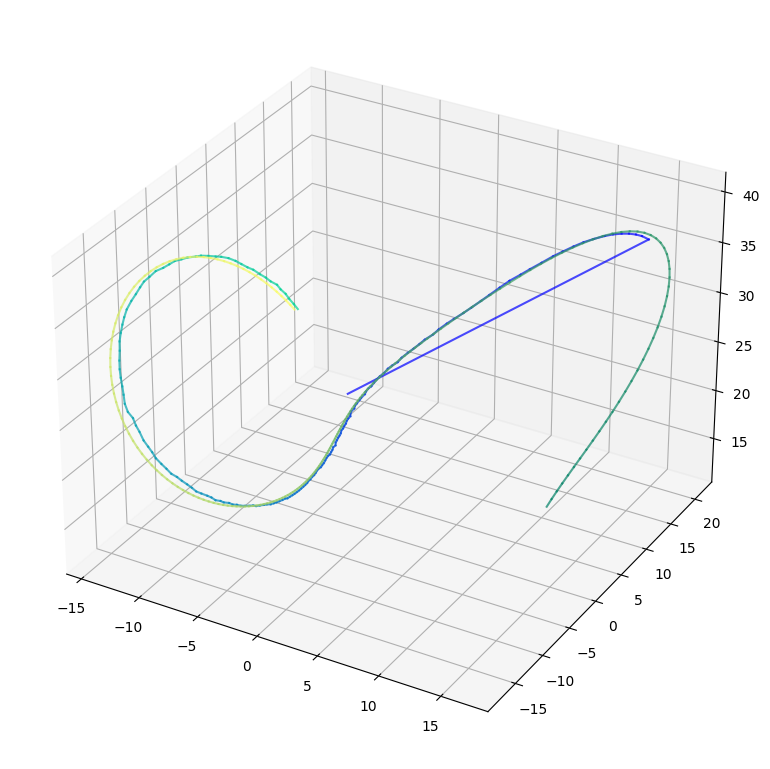

MSE over 4969 test samples: 0.01146674


In [11]:
test_mse = test_timeseries_nD(LD_inputs_tr, LD_outputs_tr, neurons, relative_dpe_weights, n_input, TS_data=LD_data_tr, bias = dpe_bias_relative, relative=True, plot_len=200, plt_fn=Lorenz.plot_data, input_warmup_only=False)
print(f'MSE over {len(LD_inputs_te)} test samples: {test_mse:.8f}')

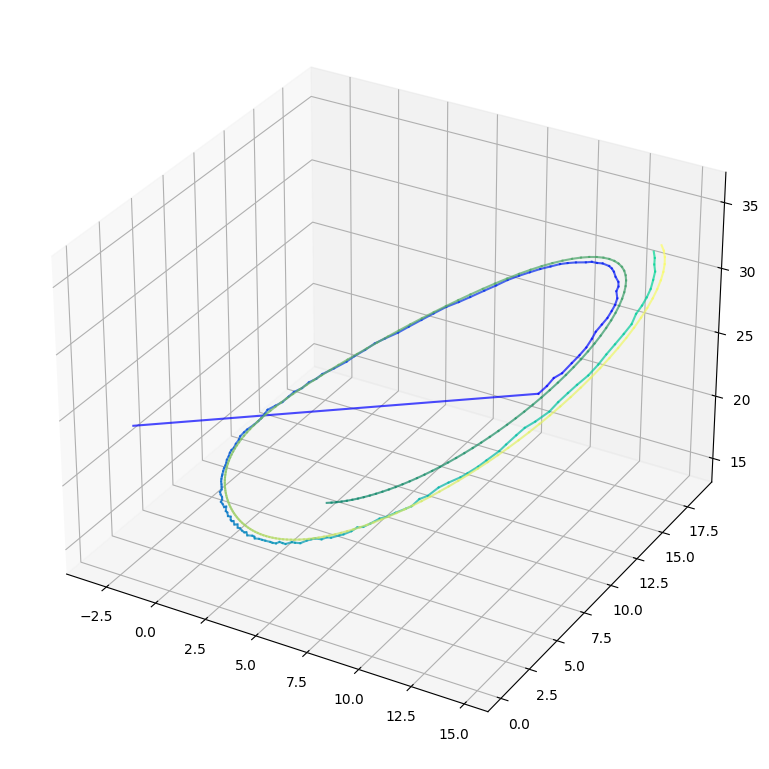

MSE over 4969 test samples: 0.01014422


In [12]:
test_mse = test_timeseries_nD(LD_inputs_te, LD_outputs_te, neurons, relative_dpe_weights, n_input, TS_data=LD_data_te, bias = dpe_bias_relative, relative=True, plot_len=200, plt_fn=Lorenz.plot_data, input_warmup_only=False)
print(f'MSE over {len(LD_inputs_te)} test samples: {test_mse:.8f}')